In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import importlib
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from itertools import product
from collections import defaultdict

In [3]:
# 获取项目根目录
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')

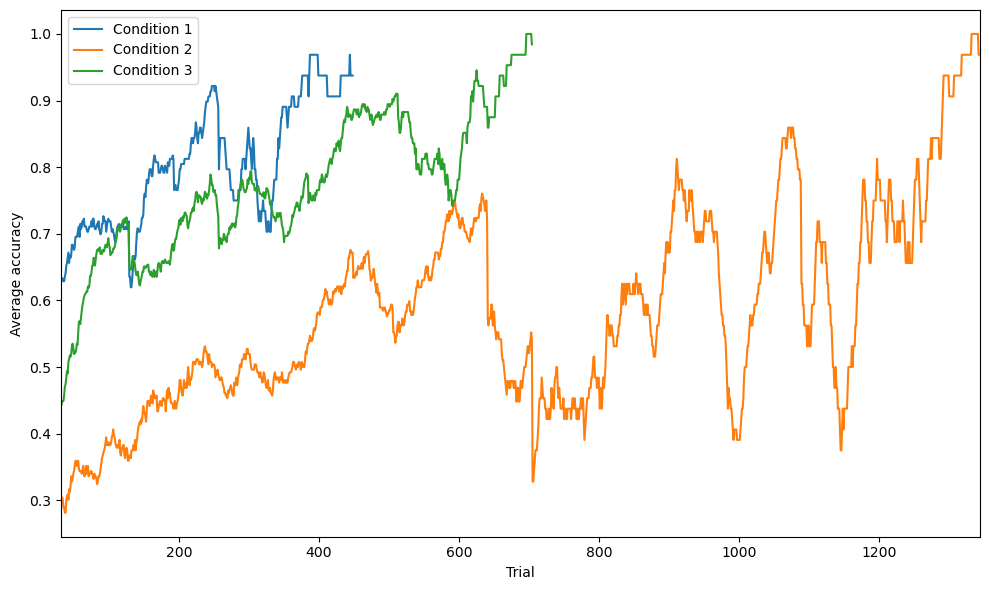

In [13]:
window_size = 32

# 1. 按 iSub, condition, iSession, iTrial 排序，并计算每组的 trial_count（连续编号）
df_sorted = learning_data.sort_values(['iSub', 'condition', 'iSession', 'iTrial'])
df_sorted['trial_count'] = (
    df_sorted
    .groupby(['iSub', 'condition'])
    .cumcount() + 1
)

# 2. 基于 trial_count 按组（iSub+condition）计算滑窗平均
df_sorted['rolling_acc'] = (
    df_sorted
    .groupby(['iSub', 'condition'])['feedback']
    .rolling(window=window_size)
    .mean()
    .reset_index(level=[0,1], drop=True)
)

# 3. 丢弃 NaN 并记录滑窗结束位置
df_rolling = df_sorted.dropna(subset=['rolling_acc']).copy()
df_rolling['window_end'] = df_rolling['trial_count']

# 4. 计算各 condition 下每个 window_end 的平均滚动正确率
avg = (
    df_rolling
    .groupby(['condition', 'window_end'])['rolling_acc']
    .mean()
    .reset_index()
)
pivot = avg.pivot(index='window_end', columns='condition', values='rolling_acc')

# 5. 扩展到所有可能的 trial_count 以对齐最长序列
max_trial = df_rolling['window_end'].max()
full_idx = range(window_size, max_trial + 1)
pivot = pivot.reindex(full_idx)

# 6. 绘图
plt.figure(figsize=(10, 6))
for cond in pivot.columns:
    plt.plot(pivot.index, pivot[cond], label=f'Condition {cond}')
plt.xlabel('Trial')
plt.ylabel(f'Average accuracy')
plt.xlim(window_size, max_trial)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
window_size = 16

# 1. 按 iSub, iSession, iTrial 排序，并计算累积 trial 序号
df_sub = learning_data.sort_values(['iSub', 'iSession', 'iTrial'])
df_sub['trial_sub_count'] = df_sub.groupby('iSub').cumcount() + 1

# 2. 计算每个被试的 sliding window 正确率
df_sub['rolling_acc'] = (
    df_sub
    .groupby('iSub')['feedback']
    .rolling(window=window_size)
    .mean()
    .reset_index(level=0, drop=True)
)

# 3. 丢弃 NaN，筛选出 rolling_acc > 0.75 的记录
df_valid = df_sub.dropna(subset=['rolling_acc'])
df_over = df_valid[df_valid['rolling_acc'] > 0.75]

# 4. 获取每个被试最后一次满足条件的 trial_sub_count
last_over = (
    df_over
    .groupby('iSub')['trial_sub_count']
    .max()
    .reset_index(name='last_trial_over_075')
)

# 5. 计算均值与标准差
mean_val = last_over['last_trial_over_075'].mean()
std_val = last_over['last_trial_over_075'].std()


mean_val, std_val

(469.0, 305.8042852374133)

#### Fig 1C

In [171]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig1_Ntrial

# 初始化处理器
plot_fig1_ntrial = Fig1_Ntrial()

In [187]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
plot_fig1_ntrial.plot_trial_number(learning_data,iCon=1,
                                figsize=(2, 6.2),
                                color='#A6A6A6',
                                save_path=plots_dir / 'Fig1D_ntrial.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig1D_ntrial.svg


#### Fig 1D

In [5]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig1_Acc

# 初始化处理器
plot_fig1_acc = Fig1_Acc()

In [15]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
plot_fig1_acc.plot_accuracy(learning_data,
                            subject_ids=[1,4],
                            subfig=1,
                            nrow=2,
                            window_size=16,
                            block_size=64,
                            h_pad=8.8,
                            color='#986E56',
                            max_trial=192,
                            figsize=(2.3, 5.5),
                            save_path=plots_dir / 'Fig1D_accuracy_1.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig1D_accuracy_1.svg


In [20]:
plot_fig1_acc.plot_accuracy(learning_data,
                            subject_ids=[7,10,13,19,22,16],
                            subfig=2,
                            nrow=2,
                            window_size=16,
                            block_size=64,
                            h_pad=8,
                            color=['#875443','#3F2219'],
                            sub_text=[3,4,5,6,7,8],
                            figsize=(10.5, 5.5),
                            save_path=plots_dir / 'Fig1D_accuracy_2.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig1D_accuracy_2.svg


#### Fig 1E

In [4]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig1_Oral

# 初始化处理器
plot_fig1_oral = Fig1_Oral()

##### subject-1

In [72]:
# 导入被试数据
iSub = 7
subject_data = learning_data[learning_data['iSub'] == iSub]
subject_data = subject_data.reset_index(drop=True)
ncats=2

# 绘制单帧图片
plots_dir = Path(project_root) / 'results' / 'Nips_figures' 
plot_fig1_oral.plot_human_trajactory(ncats, subject_data, 1, plots_dir, row_indices=248)

完成：仅绘制行 [248]，图表已保存至 /home/yangjiong/CategoryLearning/results/Nips_figures/choice*/ 文件夹。


In [73]:
iSub = 7
subject_data = learning_data[learning_data['iSub'] == iSub]
subject_data = subject_data.reset_index(drop=True)
ncats=2

plot_fig1_oral.plot_human_trajactory(ncats, subject_data, 2, plots_dir, 112, 248, 248)

完成：仅绘制行 [248]，图表已保存至 /home/yangjiong/CategoryLearning/results/Nips_figures/choice*/ 文件夹。


##### subject-2

In [81]:
# 导入被试数据
iSub = 1
subject_data = learning_data[learning_data['iSub'] == iSub]
subject_data = subject_data.reset_index(drop=True)
ncats=2

# 绘制单帧图片
plots_dir = Path(project_root) / 'results' / 'Nips_figures' 
plot_fig1_oral.plot_human_trajactory(ncats, subject_data, 1, plots_dir, row_indices=127)

完成：仅绘制行 [127]，图表已保存至 /home/yangjiong/CategoryLearning/results/Nips_figures/choice*/ 文件夹。


In [82]:
iSub = 1
subject_data = learning_data[learning_data['iSub'] == iSub]
subject_data = subject_data.reset_index(drop=True)
ncats=2

plot_fig1_oral.plot_human_trajactory(ncats, subject_data, 2, plots_dir, 68, 127, 127)

完成：仅绘制行 [127]，图表已保存至 /home/yangjiong/CategoryLearning/results/Nips_figures/choice*/ 文件夹。


##### model

In [ ]:
# 导入模型数据
result_path = Path(project_root) / 'results' / 'Model_results'
fitting_results = joblib.load(result_path / 'M0_base.joblib')

In [ ]:
import src.Bayesian.problems.model as model
importlib.reload(model)
from src.Bayesian.problems.model import SingleRationalModel

import src.Bayesian.problems.config as config
importlib.reload(config)
from src.Bayesian.problems.config import config_base

In [86]:
iSub = 7
sub_result = fitting_results[iSub]
step_results = sub_result['best_step_results']
cond = sub_result['condition']

model  = SingleRationalModel(config_base, condition=cond)
model_centers = plot_fig1_oral.get_model_centers(step_results,
                                                 model,
                                                 ncats=ncats)
model_centers['iSub']     = iSub
model_centers['iTrial']   = model_centers.index + 1

In [94]:
# 绘制单帧图片
plots_dir = Path(project_root) / 'results' / 'Nips_figures' 
plot_fig1_oral.plot_model_trajactory(ncats, model_centers, 1, plots_dir, row_indices=29)

完成模型轨迹绘制：行 [29]，图表已保存至 /home/yangjiong/CategoryLearning/results/Nips_figures/choice*/ 文件夹。


In [89]:
plot_fig1_oral.plot_model_trajactory(ncats, model_centers, 2, plots_dir, 30, 30, 29)

完成模型轨迹绘制：行 [29]，图表已保存至 /home/yangjiong/CategoryLearning/results/Nips_figures/choice*/ 文件夹。


#### Fig 2A

In [142]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig2_Partition

# 初始化处理器
plot_fig2_partition = Fig2_Partition()

In [143]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final' 
plot_fig2_partition.plot(i=1, save_path=plots_dir / 'Fig2_partition_1.svg')

In [144]:
plot_fig2_partition.plot(i=2, save_path=plots_dir / 'Fig2_partition_2.svg')

In [145]:
plot_fig2_partition.plot(i=3, save_path=plots_dir / 'Fig2_partition_3.svg')

#### Fig 3A

In [4]:
# 加载拟合结果
result_path = Path(project_root) / 'results' / 'Model_results'
M0_results = joblib.load(result_path / 'M0_Base.joblib')
M1_results = joblib.load(result_path / 'M1_P.joblib')
M2_results = joblib.load(result_path / 'M2_M.joblib')
M3_results = joblib.load(result_path / 'M3_H.joblib')
M4_results = joblib.load(result_path / 'M4_PM.joblib')
M5_results = joblib.load(result_path / 'M5_PH.joblib')
M6_results = joblib.load(result_path / 'M6_MH.joblib')
M7_results = joblib.load(result_path / 'M7_PMH.joblib')

In [ ]:
from src.Bayesian import *
from src.Bayesian.problems.config import config_fgt
from src.Bayesian.problems import *
from src.Bayesian.utils.optimizer import Optimizer

optimizer = Optimizer({}, n_jobs=1)
processed_path = Path(project_root) / 'data' / 'processed'
optimizer.prepare_data(processed_path / 'Task2_processed.csv')

In [120]:
def get_prediction(fitting_results):
    optimizer.set_results(fitting_results)
    predict_results = optimizer.predict_with_subs_parallel(config_fgt,list(range(1, 25)))
    return predict_results

In [ ]:
M0_predict_results = get_prediction(M0_results)
M1_predict_results = get_prediction(M1_results)
M2_predict_results = get_prediction(M2_results)
M3_predict_results = get_prediction(M3_results)
M4_predict_results = get_prediction(M4_results)
M5_predict_results = get_prediction(M5_results)
M6_predict_results = get_prediction(M6_results)
M7_predict_results = get_prediction(M7_results)

Predicting tasks:   0%|                                                      | 0/24 [00:00<?, ?it/s]

Predicting tasks: 100%|█████████████████████████████████████████████| 24/24 [00:01<00:00, 15.84it/s]


In [ ]:
joblib.dump(M0_predict_results, result_path / 'M0_Base_predict.joblib')
joblib.dump(M1_predict_results, result_path / 'M1_P_predict.joblib')
joblib.dump(M2_predict_results, result_path / 'M2_M_predict.joblib')
joblib.dump(M3_predict_results, result_path / 'M3_H_predict.joblib')
joblib.dump(M4_predict_results, result_path / 'M4_PM_predict.joblib')
joblib.dump(M5_predict_results, result_path / 'M5_PH_predict.joblib')
joblib.dump(M6_predict_results, result_path / 'M6_MH_predict.joblib')
joblib.dump(M7_predict_results, result_path / 'M7_PMH_predict.joblib')

In [7]:
# 加载结果
result_path = Path(project_root) / 'results' / 'Model_results'
M0_predict_results = joblib.load(result_path / 'M0_Base_predict.joblib')
M1_predict_results = joblib.load(result_path / 'M1_P_predict.joblib')
M2_predict_results = joblib.load(result_path / 'M2_M_predict.joblib')
M3_predict_results = joblib.load(result_path / 'M3_H_predict.joblib')
M4_predict_results = joblib.load(result_path / 'M4_PM_predict.joblib')
M5_predict_results = joblib.load(result_path / 'M5_PH_predict.joblib')
M6_predict_results = joblib.load(result_path / 'M6_MH_predict.joblib')
M7_predict_results = joblib.load(result_path / 'M7_PMH_predict.joblib')

In [9]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig3_Group

# 初始化处理器
plot_fig3 = Fig3_Group()

In [ ]:
# plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
# plot_fig3.plot_group_aic(results_list=[M0_predict_results,M1_predict_results,M2_predict_results,
# M3_predict_results,M4_predict_results,M5_predict_results,M6_predict_results,M7_predict_results],
#                               mc_method='fdr_bh',
#                               figsize=(8, 5),
#                               save_path=plots_dir / 'Fig3B_aic.png')

In [10]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
plot_fig3.plot_group_acc_error(results_list=[M0_predict_results,M1_predict_results,M3_predict_results,
                                             M5_predict_results,M2_predict_results,M4_predict_results,
                                             M6_predict_results,M7_predict_results],
                              mc_method='fdr_bh',
                              figsize=(8.2, 4),
                              labels=['Base','P','H','PH','M','PM','MH','PMH'],
                              save_path=plots_dir / 'Fig3A_acc_error.svg')


=== Pairwise Comparison Summary ===
Model Base vs P:
  Normality of differences: PASS (p = 0.2988)
  Paired t-test p = 0.0000
  Wilcoxon test p = 0.0000
  => REJECT after correction (method: fdr_bh)

Model P vs H:
  Normality of differences: PASS (p = 0.0970)
  Paired t-test p = 0.0006
  Wilcoxon test p = 0.0018
  => REJECT after correction (method: fdr_bh)

Model H vs PH:
  Normality of differences: PASS (p = 0.0772)
  Paired t-test p = 0.1672
  Wilcoxon test p = 0.0691
  => n.s. after correction (method: fdr_bh)

Model PH vs M:
  Normality of differences: PASS (p = 0.0854)
  Paired t-test p = 0.0000
  Wilcoxon test p = 0.0000
  => REJECT after correction (method: fdr_bh)

Model M vs PM:
  Normality of differences: FAIL (p = 0.0009)
  Paired t-test p = 0.0000
  Wilcoxon test p = 0.0000
  => REJECT after correction (method: fdr_bh)

Model PM vs MH:
  Normality of differences: PASS (p = 0.6499)
  Paired t-test p = 0.8905
  Wilcoxon test p = 0.7257
  => n.s. after correction (method: fd

In [44]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
plot_fig3.plot_group_acc_error(results_list=[M0_predict_results,M1_predict_results,M3_predict_results,
                                             M5_predict_results,M2_predict_results,M4_predict_results,
                                             M6_predict_results,M7_predict_results],
                              mc_method='fdr_bh',
                              figsize=(8.2, 4),
                              labels=['Base','P','H','PH','M','PM','MH','PMH'],
                              save_path=plots_dir / 'Fig3A_acc_error.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig3A_acc_error.svg
Raw p-values:         [0.     0.0003 0.0023 0.     0.2032 0.0484 0.2613]
Corrected p-values (fdr_bh): [0.     0.0007 0.004  0.     0.237  0.0678 0.2613]
Reject null hypotheses: [ True  True  True  True False False False]


In [11]:
oral_hypo_hits = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'oral_hypo_hits.joblib')

In [58]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
plot_fig3.plot_group_k_error(oral_hypo_hits=oral_hypo_hits,
                             results_list=[M0_results,M1_results,M3_results,
                                      M5_results,M2_results,M4_results,
                                      M6_results,M7_results],
                              mc_method='fdr_bh',
                              figsize=(8.2, 4),
                              labels=['Base','P','H','PH','M','PM','MH','PMH'],
                              save_path=plots_dir / 'Fig3A_k_error.svg')

Raw p-values:         [4.00e-04 0.00e+00 6.54e-01 0.00e+00 3.00e-04 3.20e-03 1.00e-03]
Corrected p-values (fdr_bh): [7.00e-04 1.00e-04 6.54e-01 1.00e-04 6.00e-04 3.80e-03 1.40e-03]
Reject null hypotheses: [ True  True False  True  True  True  True]


In [13]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
plot_fig3.plot_group_k_corr(oral_hypo_hits=oral_hypo_hits,
                             results_list=[M0_results,M1_results,M3_results,
                                      M5_results,M2_results,M4_results,
                                      M6_results,M7_results],
                              mc_method='fdr_bh',
                              figsize=(6, 5),
                            #   colors='#DDAA33',
                              labels=['Base','P','H','PH','M','PM','MH','PMH'],
                              save_path=plots_dir / 'Fig3A_k_corr.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig3A_k_corr.svg
Raw p-values:         [0.0014 0.     0.7029 0.     0.4963 0.0874 0.013 ]
Corrected p-values (fdr_bh): [0.0033 0.     0.7029 0.     0.579  0.1223 0.0227]
Reject null hypotheses: [ True  True False  True False False  True]


In [15]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
plot_fig3.plot_group_k_rdelta(oral_hypo_hits=oral_hypo_hits,
                             results_list=[M0_results,M1_results,M3_results,
                                      M5_results,M2_results,M4_results,
                                      M6_results,M7_results],
                              mc_method='fdr_bh',
                              figsize=(6, 5),
                            #   colors='#DDAA33',
                              labels=['Base','P','H','PH','M','PM','MH','PMH'],
                              save_path=plots_dir / 'Fig3A_k_rdelta.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig3A_k_rdelta.svg
Raw p-values:         [0.2838 0.1881 0.9529 0.0132 0.3194 0.8294 0.4695]
Corrected p-values (fdr_bh): [0.5589 0.5589 0.9529 0.0924 0.5589 0.9529 0.6574]
Reject null hypotheses: [False False False False False False False]


#### Fig 3B

In [48]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig3_Individual

# 初始化处理器
plot_fig3_individual = Fig3_Individual()

In [70]:
subject_id = 17
subject_label = 14
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
plot_fig3_individual.plot_acc_comparison(results=M7_predict_results,
                              subject_id=subject_id,
                              color='#B38665',
                              color_true='#A6A6A6',
                              xtick_interval=128,
                              subject_label=f'{subject_label}',
                              model_label='PMH',
                              figsize=(8, 4.2),
                              save_path=plots_dir / f'Fig3B_acc_{subject_id}.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig3B_acc_17.svg


In [65]:
oral_hypo_hits = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'oral_hypo_hits.joblib')

In [113]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
plot_fig3_individual.plot_k_comparison(oral_hypo_hits,
                             results=M7_results,
                             subject_id=subject_id,
                             color='#20978B',
                             color_true='#A6A6A6',
                             xtick_interval=128,
                             subject_label=f'{subject_label}',
                             model_label='PMH',
                             figsize=(8, 3.3),
                             save_path=plots_dir / f'Fig3B_k_{subject_id}.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig3B_k_17.svg


#### Fig 3C

In [53]:
subject_ids = [7, 16, 5, 12]
subject_labels = [3, 6, 9, 20]

In [54]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
plot_fig3_individual.plot_acc_comparison_subs(results=M7_predict_results,
                                subject_ids=subject_ids,
                                nrow=2,
                                color='#B38665',
                                color_true='#A6A6A6',
                                xtick_interval=128,
                                subject_labels=subject_labels,
                                figsize=(8, 7),
                                save_path=plots_dir / f'Fig3C_acc.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig3C_acc.svg


In [55]:
for subject_id in subject_ids:
    plot_fig3_individual.plot_k_comparison_small(oral_hypo_hits,
                                 results=M7_results,
                                 subject_id=subject_id,
                                 figsize=(3, 1.7),
                                 color='#20978B',
                                 color_true='#A6A6A6',
                                 xtick_interval=128,
                                 save_path=plots_dir / f'Fig3C_k_{subject_id}.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig3C_k_7.svg
Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig3C_k_16.svg
Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig3C_k_5.svg
Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig3C_k_12.svg


#### Fig 4

In [59]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig4

# 初始化处理器
plot_fig4 = Fig4()

In [56]:
subject_id = 14
subject_label = 13
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
plot_fig4.plot_acc_comparison_models(results_list=[M2_predict_results,M3_predict_results,M0_predict_results],
                                subject_id=subject_id,
                                colors=['#FFC000','#AD78D7','#404040'],
                                color_true='#A6A6A6',
                                xtick_interval=128,
                                subject_label=f'{subject_label}',
                                model_labels=['M-only','H-only','Base'],
                                figsize=(17.3, 3.7),
                                width_ratios=[0.46,0.27,0.27],
                                save_path=plots_dir / f'Fig4A_acc_{subject_id}.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig4A_acc_14.svg


In [36]:
oral_hypo_hits = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'oral_hypo_hits.joblib')

In [62]:
subject_id = 17
subject_label = 14
plot_fig4.plot_k_comparison_models(oral_hypo_hits=oral_hypo_hits,
    results_list=[M2_results, M3_results, M0_results],
    subject_id=subject_id,
    colors=['#FFC000', '#AD78D7', '#404040'],
    color_true='#A6A6A6',
    xtick_interval=128,
    subject_label=f'{subject_label}',
    model_labels=['M-only', 'H-only', 'Base'],
    figsize=(16.6, 3.6),
    width_ratios=[0.46, 0.27, 0.27],
    save_path=plots_dir / f'Fig4B_k_{subject_id}.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig4B_k_17.svg


#### Fig 5A

In [97]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig5

# 初始化处理器
plot_fig5 = Fig5()

In [ ]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
plot_fig5.plot_amount(results=M7_results,
                             subject_id=17,
                             figsize=(8, 4.2),
                             color_1='#C9AAE6',
                             color_2='#7B3BB7',
                             label_1='Exploitation',
                             label_2='Exploration',
                             save_path=plots_dir / 'Fig5A_amount.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig5A_amount.svg


In [85]:
results = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'M_fgt_cl.joblib')

In [111]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
plot_fig5.plot_correlation(results=results,
                             figsize=(6, 4.2),
                             save_path=plots_dir / 'Fig5B_correlation.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig5B_correlation.svg


#### Fig S1C

#### Fig S2

In [64]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig1_Acc

# 初始化处理器
plot_fig1_acc = Fig1_Acc()

In [ ]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
plot_fig1_acc.plot_accuracy(learning_data,
                            subject_ids=[9,18,24],
                            subfig=1,
                            nrow=2,
                            window_size=16,
                            block_size=64,
                            h_pad=8.8,
                            color='#986E56',
                            sub_text=[19,22,24],
                            # max_trial=192,
                            figsize=(4, 5.5),
                            save_path=plots_dir / 'FigS2_accuracy_con3_1.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/FigS2_accuracy_con3_1.svg


In [ ]:
plot_fig1_acc.plot_accuracy(learning_data,
                            subject_ids=[6,12,21,3,15],
                            subfig=2,
                            nrow=2,
                            window_size=16,
                            block_size=64,
                            h_pad=8,
                            color=['#875443','#3F2219'],
                            sub_text=[18,20,23,17,21],
                            figsize=(12, 5.5),
                            save_path=plots_dir / 'FigS2_accuracy_con3_2.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/FigS2_accuracy_con3_2.svg


In [80]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
plot_fig1_acc.plot_accuracy(learning_data,
                            subject_ids=[8,23],
                            subfig=1,
                            nrow=2,
                            window_size=16,
                            block_size=64,
                            xtick_interval=256,
                            h_pad=8.8,
                            color='#986E56',
                            sub_text=[11,16],
                            max_trial=512,
                            figsize=(3, 5.5),
                            save_path=plots_dir / 'FigS2_accuracy_con2_1.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/FigS2_accuracy_con2_1.svg


In [81]:
plot_fig1_acc.plot_accuracy(learning_data,
                            subject_ids=[5,11,14,2,17,20],
                            subfig=2,
                            nrow=2,
                            window_size=16,
                            block_size=64,
                            xtick_interval=256,
                            h_pad=8,
                            color=['#875443','#3F2219'],
                            sub_text=[10,12,13,9,14,15],
                            figsize=(15, 5.5),
                            save_path=plots_dir / 'FigS2_accuracy_con2_2.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/FigS2_accuracy_con2_2.svg


#### Fig S3

In [5]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import FigS3

# 初始化处理器
plot_figs3 = FigS3()

In [6]:
subject_ids = [1,4,7,10,13,19,22,16,3,6,9,12,15,18,21,24,2,5,8,11,14,17,20,23]
subject_labels = [1,2,3,4,5,6,7,8,17,18,19,20,21,22,23,24,9,10,11,12,13,14,15,16]

In [105]:
oral_hypo_hits = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'oral_hypo_hits.joblib')

In [125]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
for model in ['M0', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7']:
    results = globals()[f"{model}_predict_results"]
    plot_figs3.plot_acc_comparison_subs(results=results,
                                        subject_ids=subject_ids,
                                        nrow=6,
                                        color='#B38665',
                                        color_true='#A6A6A6',
                                        xtick_interval=128,
                                        subject_labels=subject_labels,
                                        figsize=(17, 10),
                                        save_path=plots_dir /
                                        f'Fig_acc_{model}.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig_acc_M0.svg
Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig_acc_M1.svg
Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig_acc_M2.svg
Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig_acc_M3.svg
Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig_acc_M4.svg
Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig_acc_M5.svg
Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig_acc_M6.svg
Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig_acc_M7.svg


In [126]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
for model in ['M0', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7']:
    results = globals()[f"{model}_results"]
    plot_figs3.plot_k_comparison_subs(oral_hypo_hits,
                             results=results,
                             subject_ids=subject_ids,
                             nrow=6,
                             color='#20978B',
                             color_true='#A6A6A6',
                             xtick_interval=128,
                             subject_labels=subject_labels,
                             figsize=(17, 10),
                             save_path=plots_dir /
                             f'Fig_k_{model}.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig_k_M0.svg
Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig_k_M1.svg
Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig_k_M2.svg
Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig_k_M3.svg
Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig_k_M4.svg
Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig_k_M5.svg
Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig_k_M6.svg
Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig_k_M7.svg


In [3]:
result_path = Path(project_root) / 'results' / 'Finetune'
M7_results = joblib.load(result_path / 'M7_PMH_5_1000.joblib')

In [10]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
for model in ['M7']:
    results = globals()[f"{model}_results"]
    plot_figs3.plot_grid_subs(results=results,
                             subject_ids=subject_ids,
                             nrow=6,
                             subject_labels=subject_labels,
                             figsize=(17, 15),
                             save_path=plots_dir /
                             f'Fig_grid_{model}.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig_grid_M7.svg


In [12]:
result_path = Path(project_root) / 'results' / 'Model_results'
M7_results_v2 = joblib.load(result_path / 'M7_PMH.joblib')
M7_results[17] = M7_results_v2[17]

In [17]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures_final'
for model in ['M7']:
    results = globals()[f"{model}_results"]
    plot_figs3.plot_amount_subs(results=results,
                             subject_ids=subject_ids,
                             nrow=6,
                             subject_labels=subject_labels,
                             color_1='#C9AAE6',
                             color_2='#7B3BB7',
                             label_1='Exploitation',
                             label_2='Exploration',
                             figsize=(17, 10),
                             save_path=plots_dir /
                             f'Fig_amount_{model}.svg')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures_final/Fig_amount_M7.svg
